In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv(r'C:\Users\lenovo\Desktop\Phishing Domain Detection\Phishing Domain Detection\Data\dataset_cybersecurity_michelle.csv')

In [4]:
# Separar características y variable objetivo
X = df.drop('phishing', axis=1)
y = df['phishing']

In [5]:
# Verifica que X e y se crearon correctamente
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (129698, 111)
Shape of y: (129698,)


c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Top 10 características por correlación con la variable objetivo:
qty_slash_directory           0.721240
qty_hashtag_file              0.717482
qty_questionmark_directory    0.717482
qty_hashtag_directory         0.717482
qty_questionmark_file         0.717482
qty_slash_file                0.717482
qty_dollar_file               0.717482
qty_at_file                   0.717317
qty_exclamation_file          0.716787
qty_and_file                  0.716564
dtype: float64


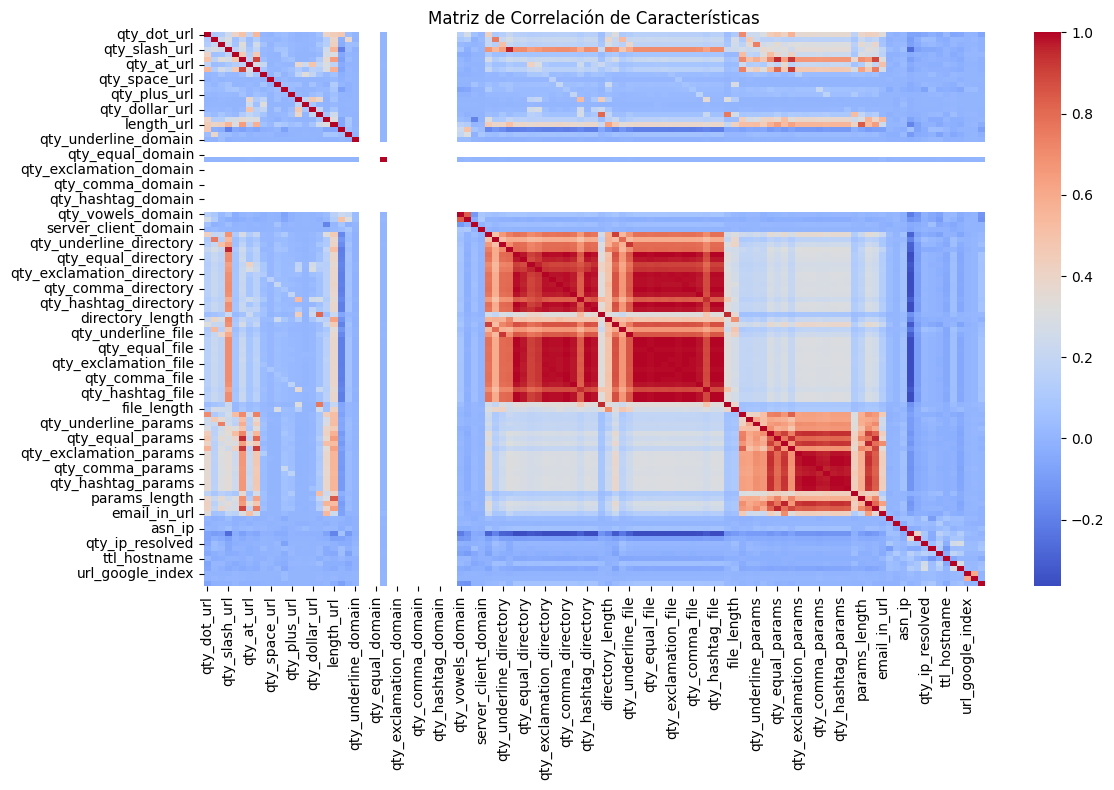

In [6]:
# 1. Correlación con la variable objetivo
correlation_with_target = X.apply(lambda x: x.corr(y) if x.dtype in ['int64', 'float64'] else np.nan)
correlation_with_target = correlation_with_target.sort_values(key=abs, ascending=False)

print("Top 10 características por correlación con la variable objetivo:")
print(correlation_with_target.head(10))

# Visualización de correlaciones
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), cmap='coolwarm', annot=False)
plt.title('Matriz de Correlación de Características')
plt.tight_layout()
plt.show()



Top 10 características por importancia en Random Forest:
directory_length          0.114456
time_domain_activation    0.068949
qty_dollar_directory      0.041275
qty_slash_directory       0.040952
qty_dot_file              0.039952
length_url                0.038814
ttl_hostname              0.028208
time_response             0.026628
asn_ip                    0.026261
qty_slash_url             0.025566
dtype: float64


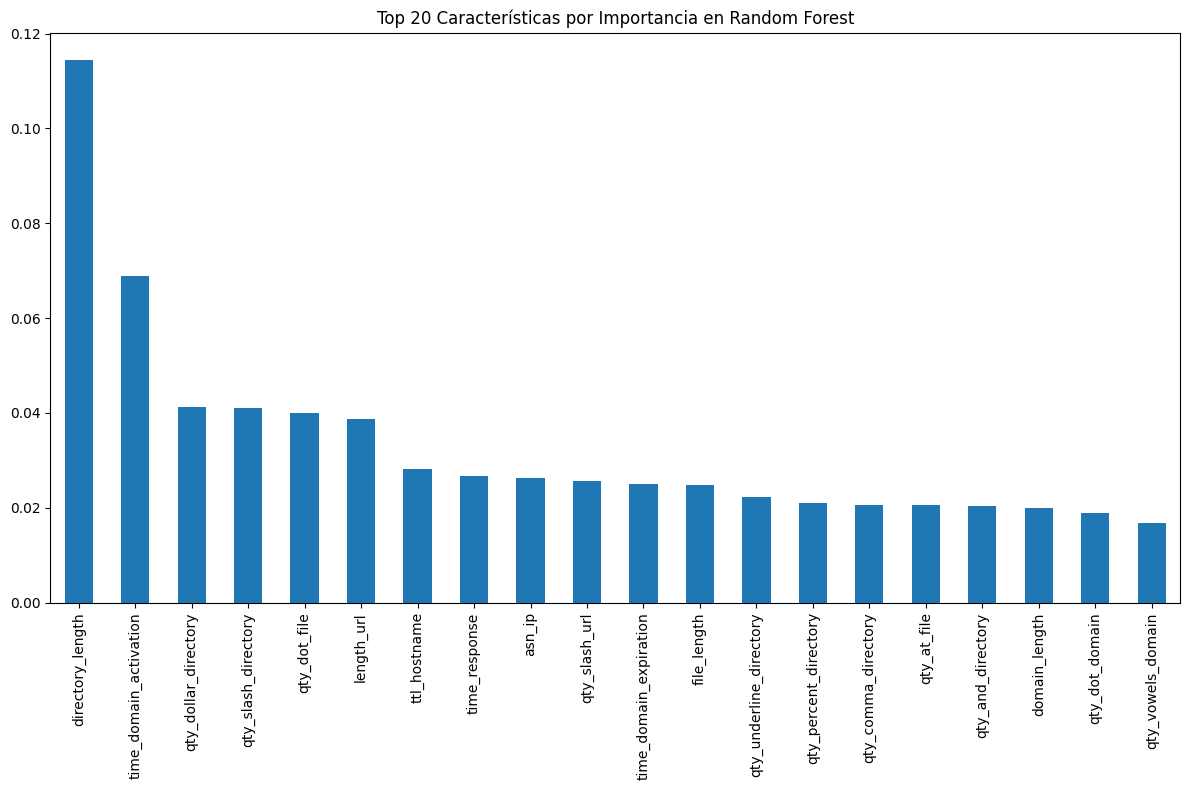

In [7]:
# 2. Importancia de características usando Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\nTop 10 características por importancia en Random Forest:")
print(feature_importance.head(10))

# Visualización de importancia de características
plt.figure(figsize=(12, 8))
feature_importance.head(20).plot(kind='bar')
plt.title('Top 20 Características por Importancia en Random Forest')
plt.tight_layout()
plt.show()

In [8]:
# 3. Selección basada en varianza
selector = VarianceThreshold(threshold=0.01)  
X_var_selected = selector.fit_transform(X)

selected_features_var = X.columns[selector.get_support()].tolist()
print(f"\nNúmero de características seleccionadas por varianza: {len(selected_features_var)}")
print("Características eliminadas por baja varianza:")
print(set(X.columns) - set(selected_features_var))


Número de características seleccionadas por varianza: 86
Características eliminadas por baja varianza:
{'qty_exclamation_domain', 'qty_hashtag_domain', 'url_google_index', 'domain_in_ip', 'qty_asterisk_domain', 'qty_hashtag_url', 'qty_percent_domain', 'qty_and_domain', 'qty_plus_domain', 'qty_at_domain', 'qty_equal_domain', 'qty_tilde_domain', 'qty_space_url', 'domain_google_index', 'url_shortened', 'qty_underline_domain', 'server_client_domain', 'qty_comma_domain', 'qty_questionmark_domain', 'qty_space_domain', 'qty_tilde_url', 'qty_comma_url', 'qty_dollar_domain', 'qty_slash_domain', 'qty_exclamation_url'}


In [9]:
# 4. Recursive Feature Elimination
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=20)
rfe = rfe.fit(X_train, y_train)

selected_features_rfe = X.columns[rfe.support_].tolist()
print("\nCaracterísticas seleccionadas por RFE:")
print(selected_features_rfe)


Características seleccionadas por RFE:
['qty_slash_url', 'length_url', 'qty_dot_domain', 'domain_length', 'qty_dot_directory', 'qty_hyphen_directory', 'qty_slash_directory', 'qty_at_directory', 'qty_and_directory', 'qty_comma_directory', 'qty_percent_directory', 'directory_length', 'qty_dot_file', 'qty_dollar_file', 'file_length', 'time_response', 'asn_ip', 'time_domain_activation', 'time_domain_expiration', 'ttl_hostname']


In [10]:
# Intersección de características seleccionadas por diferentes métodos
top_corr_features = correlation_with_target.head(20).index.tolist()
top_rf_features = feature_importance.head(20).index.tolist()

common_features = set(top_corr_features) & set(top_rf_features) & set(selected_features_rfe) & set(selected_features_var)
print("\nCaracterísticas comunes seleccionadas por todos los métodos:")
print(common_features)


Características comunes seleccionadas por todos los métodos:
{'qty_slash_directory', 'qty_comma_directory'}


Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15391
           1       0.98      0.99      0.98     10549

    accuracy                           0.99     25940
   macro avg       0.99      0.99      0.99     25940
weighted avg       0.99      0.99      0.99     25940


Matriz de Confusión:
[[15213   178]
 [  149 10400]]

Área bajo la curva ROC:
0.9979827532158095


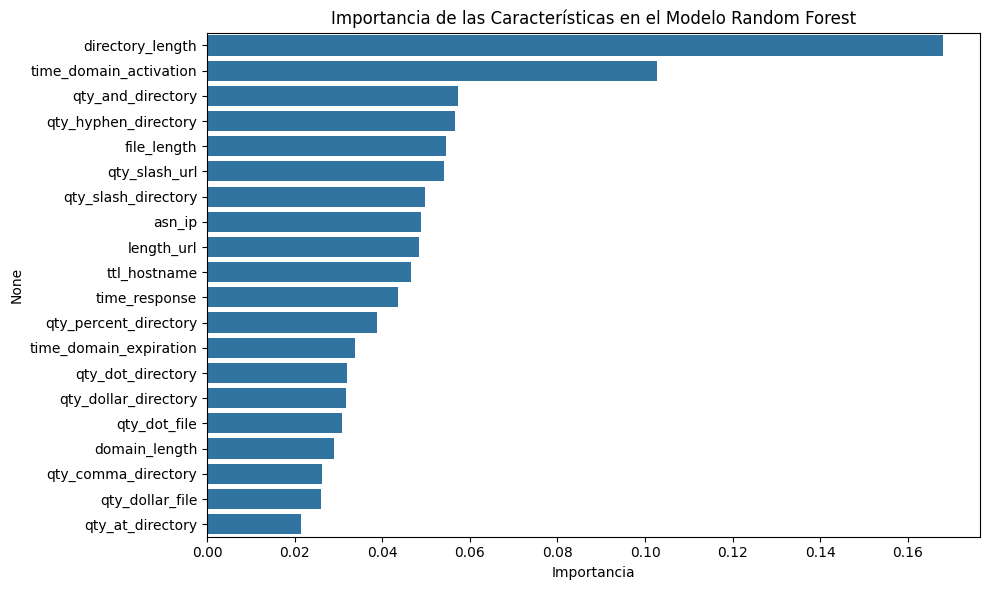

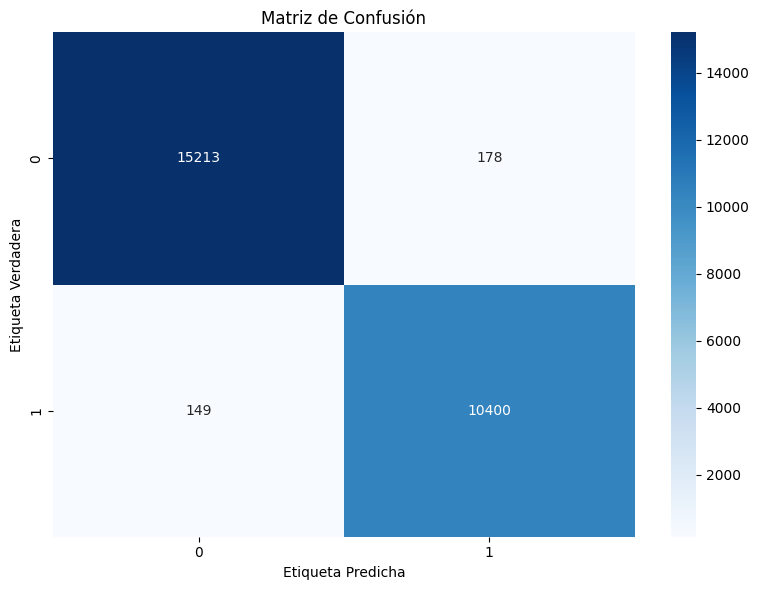

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# Lista de características seleccionadas
selected_features = [
    'directory_length', 'time_domain_activation', 'qty_dollar_directory',
    'qty_slash_directory', 'qty_dot_file', 'length_url', 'ttl_hostname',
    'time_response', 'asn_ip', 'qty_slash_url', 'qty_dot_directory',
    'qty_hyphen_directory', 'qty_at_directory', 'qty_and_directory',
    'qty_comma_directory', 'qty_percent_directory', 'qty_dollar_file',
    'file_length', 'time_domain_expiration', 'domain_length'
]

# Preparar los datos
X = df[selected_features]
y = df['phishing']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluar el modelo
print("Informe de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nÁrea bajo la curva ROC:")
print(roc_auc_score(y_test, y_pred_proba))

# Visualizar la importancia de las características
feature_importance = pd.Series(rf_model.feature_importances_, index=selected_features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Importancia de las Características en el Modelo Random Forest')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

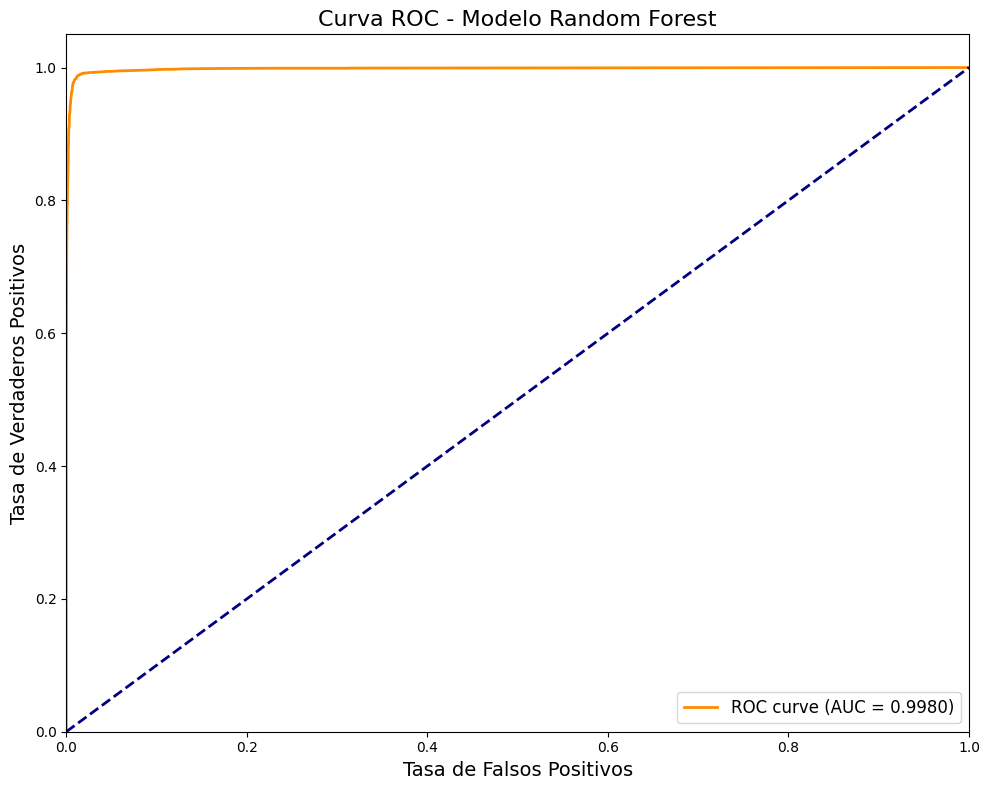

In [18]:
from sklearn.metrics import roc_curve, auc
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Crear el gráfico de la curva ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=14)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=14)
plt.title('Curva ROC - Modelo Random Forest', fontsize=16)
plt.legend(loc="lower right", fontsize=12)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 61s 15ms/step - accuracy: 0.8932 - loss: 0.2717 - val_accuracy: 0.9166 - val_loss: 0.2070
Epoch 2/100
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - accuracy: 0.9163 - loss: 0.2085 - val_accuracy: 0.9274 - val_loss: 0.1897
Epoch 3/100
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.9234 - loss: 0.1960 - val_accuracy: 0.9306 - val_loss: 0.1790
Epoch 4/100
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.9250 - loss: 0.1903 - val_accuracy: 0.9307 - val_loss: 0.1774
Epoch 5/100
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.9281 - loss: 0.1849 - val_accuracy: 0.9322 - val_loss: 0.1750
Epoch 6/100
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.9277 - loss: 0.1827 - val_accuracy: 0.9324 - val_loss: 0.1746
Epoch 7/100
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - accuracy: 0.9301 - loss: 0.1793 - val_accuracy: 0.9316 - val_loss: 0.1722
Epoch 8/100
2594/2594 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 

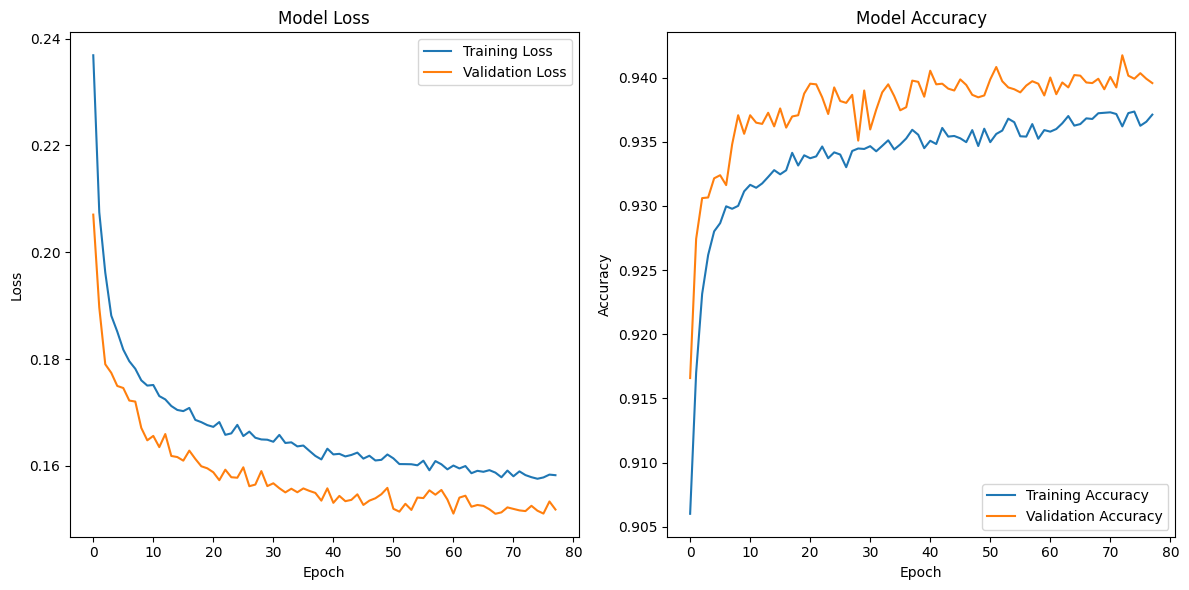

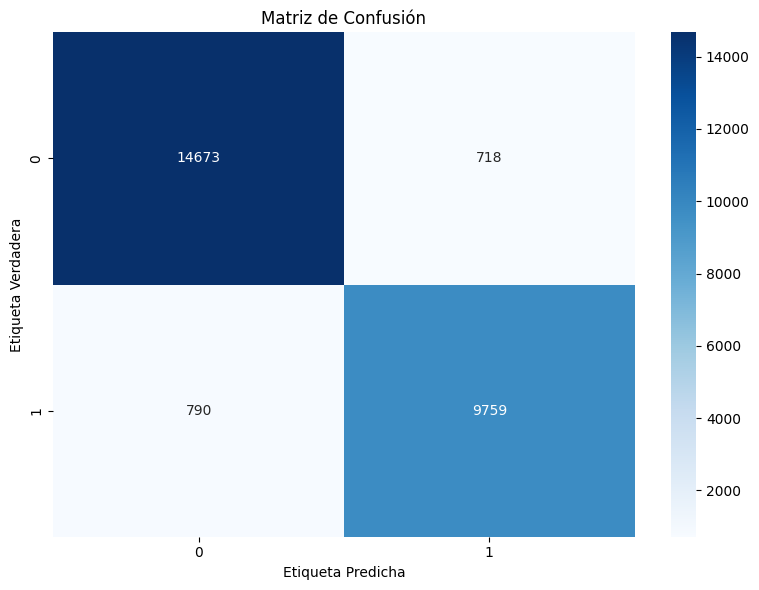

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Crear el modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Definir early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train_scaled, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)

# Evaluar el modelo
y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)

print("Informe de Clasificación:")
print(classification_report(y_test, y_pred_classes))

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

print("\nÁrea bajo la curva ROC:")
print(roc_auc_score(y_test, y_pred))

# Visualizar la curva de aprendizaje
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

In [ ]:
import joblib

# Guardar el modelo
joblib.dump(rf_model, 'random_forest_phishing_model.joblib')

# Guardar el scaler
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']